# CO543 LAB 04 PART 1

### DEVINDI G.A.I
### E/17/058

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import random


directory = "/content/drive/MyDrive/Colab Notebooks/CO543/Lab04/"


# a. Briefly describe the elbow method and the silhouette method


## Elbow method

Elbow method is one of the methods that can used to identify the optimal number of clusters (k) that can be used to cluster the test data set. 

This can be done by evaluating the Sum of Squared Distance (SSE) for a range of k values and plotting the SSE against k. The SSE or inertia of an algorithm can be used to determine the how far the datapoints inside a specific cluster are spread out. Higher inertia leads to higher accuracy.

This plot will result in a graph shaped like a bent arm similar to the below figure. The optimal k value can be defined as the spot where SSE starts to flatted out and form an elbow.

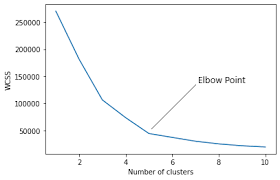

## Silhouette method

The silhouette coefficient is a measure of how similar a data point is within-cluster (cohesion) compared to other clusters (separation).

The process of silhoutte method is as follows:
1. Compute the average distance from all data points in the same cluster (ai).
2. Compute the average distance from all data points in the closest cluster(bi).
3. Compute the coefficient (Si):



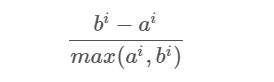

4. Then the average of the sihoutte scores are calculated as:



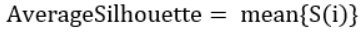

The coefficient can take values in the interval [-1, 1].
* If it is 0 –> the sample is very close to the neighboring clusters.
* If it is 1 –> the sample is far away from the neighboring clusters.
* If it is -1 –> the sample is assigned to the wrong clusters.


Therefore, the optimal k value is chosen as the k value where the average of the silhoutte coefficients is maximum and closer to 1.

# Developing the K-Means algorithm for the MNIST dataset

#Image Acquisition 

In [2]:
#read the training dataset
train_data = pd.read_csv(directory + 'train.csv')
train_data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Text(0.5, 1.0, 'Distribution of MNIST Images')

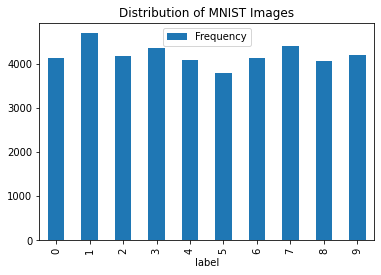

In [3]:
#display the number of occurences of each digit
train_data.groupby('label').count()[['pixel0']].rename(columns={'pixel0': 'Frequency'}).plot(kind='bar')

plt.title("Distribution of MNIST Images")

In [4]:
#read the test data set
test_data = pd.read_csv(directory + 'test.csv')
test_data.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#Image Pre processing

In [5]:
#extract the labels from the training set
train_labels = train_data['label'].to_numpy()

#remove the labels from the training set
train_set = train_data.iloc[: , 1:].to_numpy()

#divide the training data set to training and validation sets
# training data = 3/4 * train_set
# validation set = 1/4 * train_set

train_size = int (train_set.shape[0]*0.75)
train_vect  = train_set[:train_size]
valid_vect = train_set[train_size:]

#convert test dataframe to numpy vectors
test_vect = test_data.to_numpy()

print('Shape of traning data: '+ str(train_vect.shape))
print('Shape of validation data: '+ str(valid_vect.shape))
print('Shape of test data: '+ str(test_vect.shape))

Shape of traning data: (31500, 784)
Shape of validation data: (10500, 784)
Shape of test data: (28000, 784)


<Figure size 432x288 with 0 Axes>

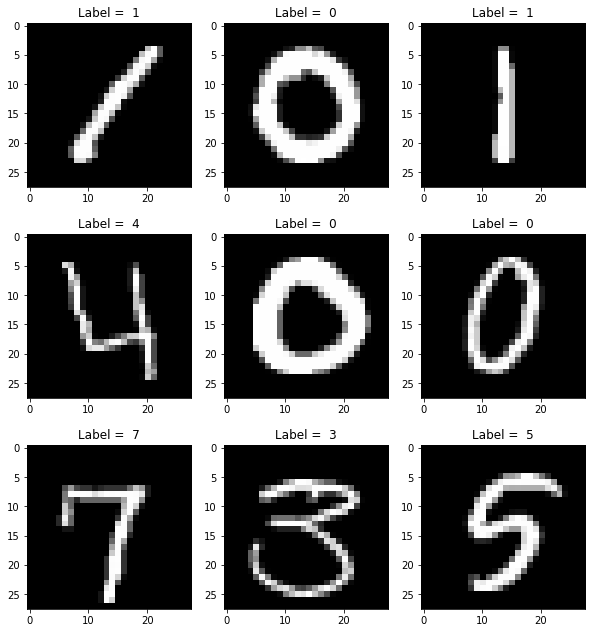

In [6]:
#display 9 images from training set
reshaped_train = train_vect.reshape(-1,28,28,1)

plt.gray() # B/W Images
plt.figure(figsize = (10,11))
for i in range(9):
 plt.subplot(3,3,i+1)
 plt.title("Label =  " + str(train_labels[i]) )
 plt.imshow(np.array(reshaped_train[i]).reshape((28,28)))
 plt.grid(False)

In [7]:
Y_train = train_labels[:train_size]

# normalize the data to 0 - 1
X_train = train_vect.astype(float) / 255.

print(X_train.shape)
print(X_train[0].shape)
print(X_train.min())

(31500, 784)
(784,)
0.0


# Apply K-Means Clustering

K-Means clustering algorithm is applied to the training dataset using the MiniBatchKMeans() function available in the scikit-learn library.

* Since the labels assigned by the algorithm for each cluster are not the digits represented in the images, supporting functions retrieve_number() and retrieve_data_labels() are used to map the labels to digits.
* calculate_metrics() function is used to calculate and print the inertia and homogeniety for varying number of clusters. metrics() function from sklearn is used in this function to calculate homogeniety

* The Elbow method was used to determine the optimum number of clusters that should be used to predict the digits.

In [8]:
#import the MiniBatchKMeans function from sklearn
from sklearn.cluster import MiniBatchKMeans

#import metrics()
from sklearn import metrics

### Helper Functions to map the cluster labels to digit labels

In [9]:
#kmeans.labels_ only denote the cluster to which the image belongs to. 
#It doesn’t denote the number displayed in image.
#retrieve_number() function is used to retrieve the number for kmeans.labels_

#returns a dictionary of clusters assigned for each label

def retrieve_number(kmeans, actual_labels):

  '''
     Associates most probable label with each cluster in KMeans model
    returns: dictionary of clusters assigned to each label
     
  '''
  inferred_labels = {}

  for i in range(kmeans.n_clusters):

        # find index of points in cluster
        labels = []
        index = np.where(kmeans.labels_ == i)

        # append actual labels for each point in cluster
        labels.append(actual_labels[index])
        #print(labels)

        # determine most common label
        if len(labels[0]) == 1:
            counts = np.bincount(labels[0])
        else:
            counts = np.bincount(np.squeeze(labels))

        # assign the cluster to a value in the inferred_labels dictionary
        if np.argmax(counts) in inferred_labels:
            # append the new number to the existing array at this slot
            inferred_labels[np.argmax(counts)].append(i)
        else:
            # create a new array in this slot
            inferred_labels[np.argmax(counts)] = [i]
              #print(labels)
        #print('Cluster: {}, label: {}'.format(i, np.argmax(counts)))
        
  return inferred_labels  
     
#Use the cluster_labels obtained by retrieve_number() and get the 
#number displayed in the images belonging to each cluster
def retrieve_data_labels(X_clusters, cluster_labels):
    """
    Determines label for each pixel array, depending on the cluster it has been assigned to.
    returns: predicted labels for each array
    """
    
    # empty array to store the predicted digit value. The length must be 
    # the len of the dataset
    predicted_labels = np.zeros(len(X_clusters)).astype(np.uint8)
    
    for i, cluster in enumerate(X_clusters):
        for key, value in cluster_labels.items():
            if cluster in value:
                predicted_labels[i] = key
                
    return predicted_labels

### Helper function to calculate and display Intertia and Homogeneity for each K

In [10]:
def calculate_metrics(estimator,labels):

    # Calculate and print metrics
    print('Number of Clusters: {}'.format(estimator.n_clusters))
    print('Inertia: {}'.format((estimator.inertia_)/10**5))
    print('Homogeneity: {}'.format(metrics.homogeneity_score(labels, estimator.labels_)))

# b. Mention the criteria behind the way you define number of clusters

Find Optimal K using the Elbow method

In [21]:
clusters =[10,64, 144, 256,512,1024,2048]
inertias = []
# test different numbers of clusters
for n_clusters in clusters:
    estimator = MiniBatchKMeans(n_clusters = n_clusters)
    estimator.fit(X_train)
    inertias.append((estimator.inertia_)/10**5)
    # print cluster metrics
    calculate_metrics(estimator, Y_train)
    
    # determine predicted labels
    cluster_labels = retrieve_number(estimator, Y_train)
    predicted_Y = retrieve_data_labels(estimator.labels_, cluster_labels)
    
    # calculate and print accuracy
    print('Accuracy: {}\n'.format(metrics.accuracy_score(Y_train, predicted_Y)))


Number of Clusters: 10
Inertia: 12.531309715577652
Homogeneity: 0.478791376171696
Accuracy: 0.5886984126984127

Number of Clusters: 64
Inertia: 9.511112222951919
Homogeneity: 0.7457620868373399
Accuracy: 0.8204444444444444

Number of Clusters: 144
Inertia: 8.494298636759266
Homogeneity: 0.8110568534884403
Accuracy: 0.8692380952380953

Number of Clusters: 256
Inertia: 7.91381582178462
Homogeneity: 0.8478662853188041
Accuracy: 0.8980952380952381

Number of Clusters: 512
Inertia: 7.16981127139002
Homogeneity: 0.8805925817508622
Accuracy: 0.9176507936507936

Number of Clusters: 1024
Inertia: 6.593252609699285
Homogeneity: 0.8971063692700096
Accuracy: 0.9234285714285714

Number of Clusters: 2048
Inertia: 5.81491784408157
Homogeneity: 0.9258292556903474
Accuracy: 0.9431111111111111



### Plot the graph of intertia for varying K

Text(0.5, 1.0, 'Elbow method for optimal K')

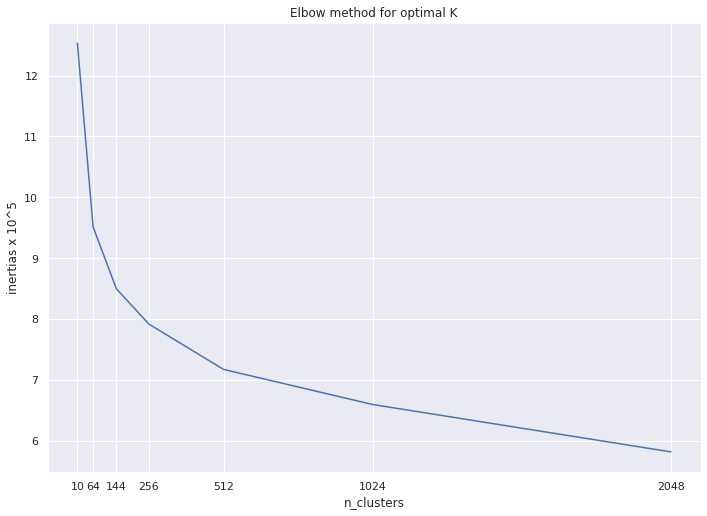

In [22]:
import seaborn as sns; sns.set()


sns.set(rc={'figure.figsize':(11.7,8.27)})
elbow_plot = pd.DataFrame({'n_clusters': clusters, 'inertias x 10^5': inertias })
sns.lineplot(x='n_clusters', y='inertias x 10^5', data=elbow_plot);
plt.xticks(clusters);
plt.title('Elbow method for optimal K')

## Criteria used to determine the number of clusters

### Determining optimal K Using the Elbow method


By looking at the above graph, it's clear that the elbow is at around K=512. Therefore, use 512 clusters for predictions.

# Fit the KMeans algorithm to the training dataset

In [23]:
#initialize and fit the KMeans algorithm on the training dataset

k = 512  #from elbow method
kmeans = MiniBatchKMeans(n_clusters = k)
kmeans.fit(X_train)


#get the digit labels for the clusters
cluster_labels = retrieve_number(kmeans, Y_train)

### Visualize the first 100 centroids for the validation dataset

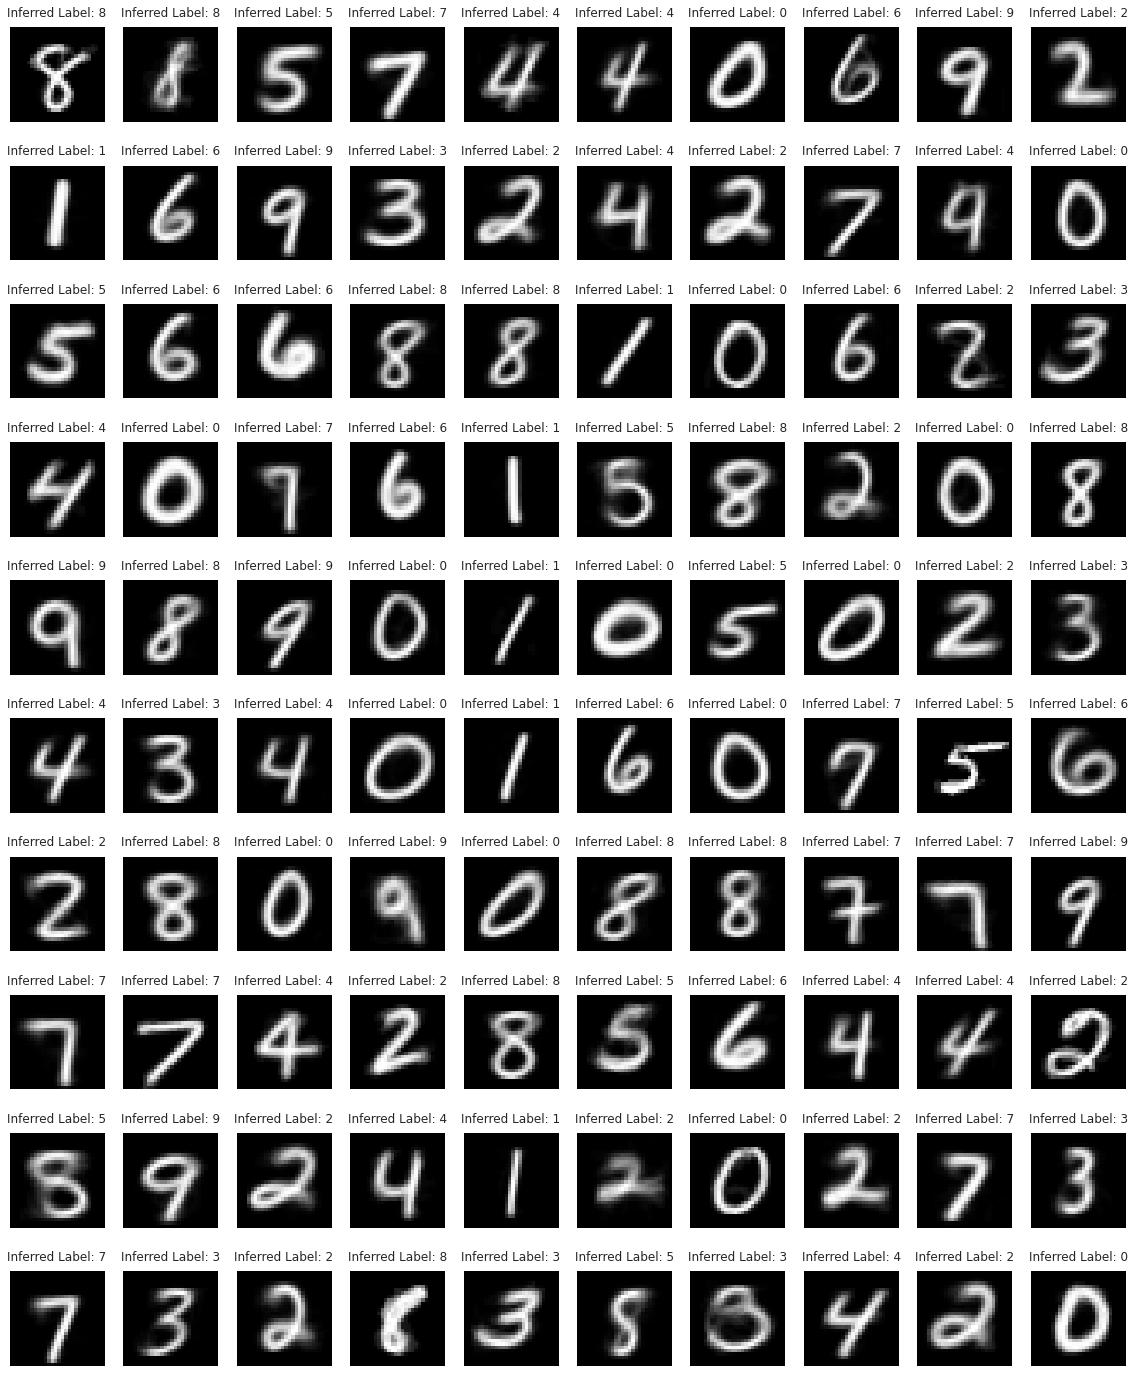

In [24]:
# record centroid values
centroids = kmeans.cluster_centers_

# reshape centroids into images
images = centroids.reshape(512, 28, 28)
images = images * 255
images = images.astype(np.uint8)

# create figure with subplots using matplotlib.pyplot
fig, axs = plt.subplots(10, 10, figsize = (20, 25))
plt.gray()

# loop through subplots and add centroid images
for i, ax in enumerate(axs.flat):
    
    # determine inferred label using cluster_labels dictionary
    for key, value in cluster_labels.items():
        if i in value:
            ax.set_title('Inferred Label: {}'.format(key))
    
    # add image to subplot
    ax.matshow(images[i])
    ax.axis('off')
    
# display the figure
fig.show()

# Validating the accuracy of the K-Means algorithm fitted to the training set using the Validation dataset

In [25]:
#Preprocess the validation dataset by normalizing
X_valid = valid_vect
X_valid = X_valid.astype(float) / 255.

#Validation labels
Y_valid = train_labels[train_size:]

In [26]:
# Predict the closest cluster to each array in validation set using the trained model.
V_clusters = kmeans.predict(X_valid)
#predict the digit labels for the validation test using train label mapping
predicted_labels = retrieve_data_labels(V_clusters, cluster_labels)
print(predicted_labels[:20])
print(Y_valid[:20])

# calculate and print accuracy
print('Accuracy: {}\n'.format(metrics.accuracy_score(Y_valid, predicted_labels)))  


[6 1 9 2 4 4 6 7 1 3 8 6 2 4 5 9 0 3 7 2]
[6 1 9 2 4 4 6 7 1 3 8 6 2 4 5 4 0 3 7 2]
Accuracy: 0.917047619047619



# Run the Algorithm with k=512 for the Test dataset

In [27]:
#Preprocess the test dataset by normalizing
X_test = test_vect
print(test_vect.shape)
X_test = X_test.astype(float) / 255.

# predict labels for testing data
test_clusters = kmeans.predict(X_test)
predicted_labels = retrieve_data_labels(test_clusters, cluster_labels)


(28000, 784)


In [43]:
# get the indices of the points for each cluster
group_by_cluster = {i: np.where(test_clusters == i)[0] for i in range(kmeans.n_clusters)}


# c. Visualize each cluster and justify the reasons for misclusted images(eg:5 is in 8’s cluster).


## Visualizing the first 20 images from the first 10 clusters out of the 512 clusters

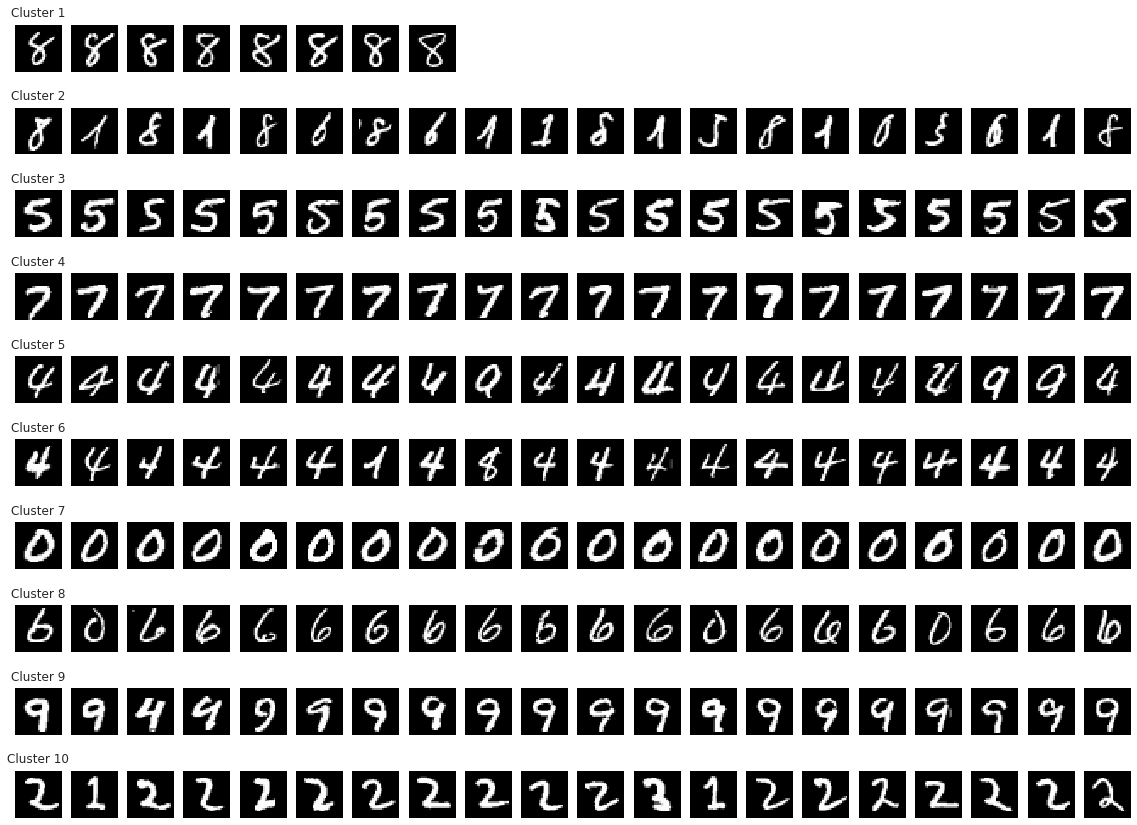

In [42]:
# display the first 20 images of the first 10 clusters
fig, axs = plt.subplots(10, 20, figsize = (20, 15))
plt.gray()
j=1
# loop through subplots and add clustered images
for i, ax in enumerate(axs.flat):
  #if a cluster has atleast 20 images, display them
  if( len(group_by_cluster[int(i/20)])>i%20):
    ax.matshow(test_vect[group_by_cluster[int(i/20)][i%20]].reshape(28, 28))
 
  ax.axis('off')
  if(i%20 == 0):
      ax.set_title('Cluster '+ str(j))
      j=j+1
  
  
# display the figure

fig.show()



## Justification for misclusted images

Observing the above image shows that there are some clusters with a mix of digits in them. 

The main reason for this could be that different patterns of handwriting results in different orientations of the same digit which could look similar to another digit. 

For example: If we take cluser 2, we can see that the digits 1,6 and 3 that have been written similar to digit 8 have been put into the same cluster by the algorithm.

Since the objective of the K-Means clustering algorithm is to categorize images of similar pattern, such different valued digits that are written is same style are present in the clusters.

# d. Suggest the ways to reduce the cluster errors.



* The accuracy of the clustering algorithm mainly depends on the initialization of the centroids at the start of the algorithm, different initializations will result in different accuracies. Smart initialization algorithms such as Kmeans++ can be used to speed up the convergence.

* Another method to reduce cluster errors is to use more number of clusters. However, large number of k can lead to overfitting.